In [52]:
import numpy as np

def get_pauli_matrices():
    I = np.eye(2, dtype=complex)
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    return I, X, Y, Z

def tensor_product(gates):
    """Compute the tensor product of a list of single-qubit gates."""
    result = gates[0]
    for g in gates[1:]:
        result = np.kron(result, g)
    return result

def ry(theta):
    """Single-qubit RY rotation."""
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2),  np.cos(theta/2)]
    ], dtype=complex)

def cnot(n, control, target):
    """Construct an n-qubit CNOT gate with given control and target indices."""
    I, X, _, _ = get_pauli_matrices()
    # Build using projector decomposition
    proj0 = np.array([[1, 0], [0, 0]], dtype=complex)
    proj1 = np.array([[0, 0], [0, 1]], dtype=complex)
    ops0 = [I]*n
    ops1 = [I]*n
    ops1[target] = X
    ops0[control] = proj0
    ops1[control] = proj1
    return tensor_product(ops0) + tensor_product(ops1)

def build_hardware_efficient_ansatz(n, L, thetas):
    """Construct the full unitary U(theta) for the hardware-efficient ansatz."""
    I, X, Y, Z = get_pauli_matrices()
    U = np.eye(2**n, dtype=complex)
    idx = 0
    # Apply L layers
    for _ in range(L):
        # Single-qubit RY rotations
        for q in range(n):
            U = ry(thetas[idx]).reshape(2, 2).dot(U.reshape((2,)*n*2)).reshape(2**n, 2**n)
            idx += 1
        # Chain of CNOTs
        for q in range(n-1):
            U = cnot(n, q, q+1).dot(U)
    return U

def transverse_field_ising_hamiltonian(n, J=1.0, h=0.5):
    """Construct the TFIM Hamiltonian for n qubits."""
    _, X, _, Z = get_pauli_matrices()
    H = np.zeros((2**n, 2**n), dtype=complex)
    # ZZ interactions
    for i in range(n-1):
        ops = [Z if j in (i, i+1) else np.eye(2) for j in range(n)]
        H -= J * tensor_product(ops)
    # X field
    for i in range(n):
        ops = [X if j == i else np.eye(2) for j in range(n)]
        H -= h * tensor_product(ops)
    return H

def expectation(U, H):
    """Compute <0|U^† H U|0>."""
    psi0 = np.zeros(2**n, dtype=complex)
    psi0[0] = 1
    psi = U.dot(psi0)
    return np.vdot(psi, H.dot(psi)).real

def compute_gradient(n, L, thetas, H, eps=1e-5):
    """Estimate gradients via finite differences."""
    grads = np.zeros_like(thetas)
    base_U = build_hardware_efficient_ansatz(n, L, thetas)
    base_E = expectation(base_U, H)
    for i in range(len(thetas)):
        thetas_forward = thetas.copy()
        thetas_forward[i] += eps
        U_fwd = build_hardware_efficient_ansatz(n, L, thetas_forward)
        E_fwd = expectation(U_fwd, H)
        grads[i] = (E_fwd - base_E) / eps
    return grads

# Parameters
n = 6    # number of qubits
L = 5    # number of layers
num_params = n * L

# Random initialization
np.random.seed(42)
thetas = np.random.uniform(0, 2*np.pi, size=num_params)

# Build Hamiltonian
H = transverse_field_ising_hamiltonian(n)

# Compute gradients
grads = compute_gradient(n, L, thetas, H)

# Display results
print(f"Gradients for n={n}, L={L}:")
print(grads)
print(f"\nGradient variance: {np.var(grads):.2e}")


Gradients for n=6, L=5:
[-0.13399236 -0.24978293  0.21630407 -0.28091702  0.671862    0.27198917
  0.13399219  0.24978107 -0.21630118  0.28092131 -0.67185785 -0.09193297
 -0.1623676  -0.76162172 -0.29048221 -0.29961699  0.03670774  0.04137118
 -0.16750154 -0.77461736  0.52912921  0.66624655  0.30104295  0.14268318
 -0.18046068 -0.25221809 -0.81319227  0.79061319  0.15162158 -0.16750154]

Gradient variance: 1.68e-01


# pennylane 

https://pennylane.ai/qml/demos/tutorial_barren_plateaus

In [53]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Operator

def build_tfim_hamiltonian(num_q: int, Delta: float = 0.5):
    """
    构造 TFIMI 哈密顿量 H = H1 + H2，
    其中 H1 包含 Z–Z 相互作用，H2 包含 X 透射场。
    
    参数：
      num_q : qubit 数量
      Delta : 透射场强度（X 项前系数）
    
    返回：
      H_sparse : qiskit.quantum_info.SparsePauliOp，稀疏保利形式
      H_matrix : numpy.ndarray，经密矩阵表示
    """
    # H1: Z_i Z_j 相互作用
    list_z = []
    coeffs_z = []
    # Z _ _ ... Z (第一项)
    op = 'Z' + 'I' * (num_q - 2) + 'Z'
    list_z.append(op)
    coeffs_z.append(1.0)
    # 链耦合 Z_i Z_{i+1}
    for i in range(num_q - 1):
        op = 'I' * i + 'ZZ' + 'I' * (num_q - i - 2)
        list_z.append(op)
        coeffs_z.append(1.0)
    # 逆序
    list_z = list_z[::-1]
    coeffs_z = coeffs_z[::-1]
    H1 = SparsePauliOp(list_z, coeffs_z)

    # H2: X_i 项
    list_x = []
    coeffs_x = []
    for i in range(num_q):
        op = 'I' * i + 'X' + 'I' * (num_q - i - 1)
        list_x.append(op)
        coeffs_x.append(Delta)
    H2 = SparsePauliOp(list_x, coeffs_x)

    # 合并
    H_sparse = SparsePauliOp.sum([H1, H2])
    H_matrix = Operator(H_sparse).data

    return H_sparse, H_matrix



_, H_dense = build_tfim_hamiltonian(num_q = 5)




In [54]:
import numpy as np
from functools import reduce

def x_tensor_n(n: int) -> np.ndarray:
    """
    构造 Pauli X 矩阵在 n 个比特上的张量积 X ⊗ X ⊗ ... ⊗ X。

    参数：
        n (int): 比特数（张量积的次数），应为正整数。

    返回：
        np.ndarray: 2^n × 2^n 的 Hermitian 矩阵。
    """
    if n < 1 or not isinstance(n, int):
        raise ValueError("n 必须是正整数。")
    # 定义单个 Pauli X 矩阵
    X = np.array([[0, 1],
                  [1, 0]], dtype=complex)
    
    # I = np.eye(2, dtype=complex)
    # mats = [X] * int(n/2) + [I] * (n - int(n/2))

    # 通过循环或 reduce 计算 n 重张量积
    mats = [X] * n

    result = reduce(lambda A, B: np.kron(A, B), mats)
    return result



In [55]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from tools import random_hermitian

In [56]:
# Set a seed for reproducibility
# np.random.seed(42)

num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)
gate_set = [qml.RX, qml.RY, qml.RZ]
# gate_set = [qml.RY]

def rand_circuit(params, random_gate_sequence=None, num_qubits=None):
    """A random variational quantum circuit.

    Args:
        params (array[float]): array of parameters
        random_gate_sequence (dict): a dictionary of random gates
        num_qubits (int): the number of qubits in the circuit

    Returns:
        float: the expectation value of the target observable
    """
    for i in range(num_qubits):
        qml.RY(np.pi / 4, wires=i)

    for i in range(num_qubits):
        random_gate_sequence[i](params[i], wires=i)

    for i in range(num_qubits - 1):
        qml.CZ(wires=[i, i + 1])

    # H = np.zeros((2 ** num_qubits, 2 ** num_qubits))
    # H[0, 0] = 1

    # _, H = build_tfim_hamiltonian(num_qubits)

    H = x_tensor_n(num_qubits)

    wirelist = [i for i in range(num_qubits)]

    # H = random_hermitian(2 ** num_qubits)

    return qml.expval(qml.Hermitian(H, wirelist))

In [57]:
grad_vals = []
num_samples = 2000

for i in range(num_samples):
    gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}
    # print(gate_sequence)
    qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
    grad = qml.grad(qcircuit, argnum=0)
    params = np.random.uniform(0, 2 * np.pi, size=num_qubits)
    gradient = grad(params, random_gate_sequence=gate_sequence, num_qubits=num_qubits)
    grad_vals.append(gradient[0])

print("Variance of the gradients for {} random circuits: {}".format(
    num_samples, np.var(grad_vals)
    )
)
print("Mean of the gradients for {} random circuits: {}".format(
    num_samples, np.mean(grad_vals)
    )
)

Variance of the gradients for 2000 random circuits: 0.004998339757171145
Mean of the gradients for 2000 random circuits: 0.0007395849379318556


In [61]:
fun_vals = []
num_samples = 2000

gate_set = [qml.RX]
for i in range(num_samples):
    gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}
    # print(gate_sequence)
    qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
    # grad = qml.grad(qcircuit, argnum=0)
    params = np.random.uniform(0, 2 * np.pi, size=num_qubits)
    fun_vals.append(qcircuit(params, random_gate_sequence=gate_sequence, num_qubits=num_qubits))
    # gradient = grad(params, random_gate_sequence=gate_sequence, num_qubits=num_qubits)
    # grad_vals.append(gradient[0])

print("Variance of the gradients for {} random circuits: {}".format(
    num_samples, np.var(fun_vals)
    )
)
print("Mean of the gradients for {} random circuits: {}".format(
    num_samples, np.mean(fun_vals)
    )
)

Variance of the gradients for 2000 random circuits: 0.0004869337892393719
Mean of the gradients for 2000 random circuits: -0.0001427006664991524


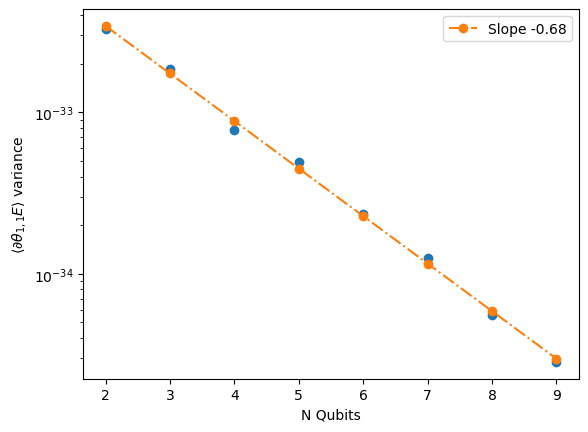

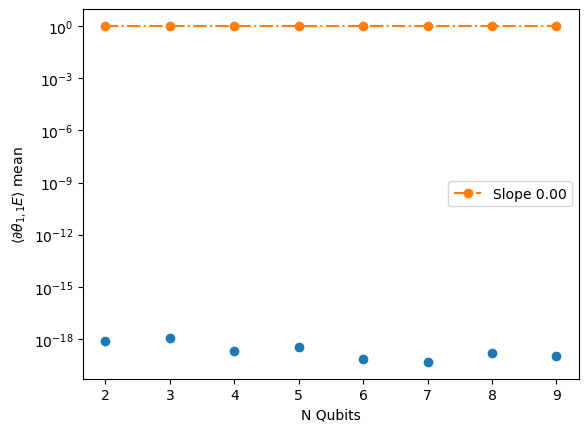

In [58]:
qubits = [2, 3, 4, 5, 6, 7, 8, 9]
variances = []
means = []


for num_qubits in qubits:
    grad_vals = []
    for i in range(num_samples):
        dev = qml.device("default.qubit", wires=num_qubits)
        qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)

        # gate_set = [qml.RX, qml.RY, qml.RZ]
        # gate_set = [qml.RX]
        gate_set = [qml.RY]
        # gate_set = [qml.RZ]
        random_gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}

        params = np.random.uniform(0, np.pi, size=num_qubits)
        gradient = grad(
            params, random_gate_sequence=random_gate_sequence, num_qubits=num_qubits
        )
        # grad_vals.append(gradient[-1])
        # 第几个偏导数都可以
        grad_vals.append(gradient[0])

    variances.append(np.var(grad_vals))
    means.append(np.mean(grad_vals))

variances = np.array(variances)
means = np.array(means)
qubits = np.array(qubits)


# Fit the semilog plot to a straight line
p = np.polyfit(qubits, np.log(variances), 1)


# Plot the straight line fit to the semilog
plt.semilogy(qubits, variances, "o")
plt.semilogy(qubits, np.exp(p[0] * qubits + p[1]), "o-.", label="Slope {:3.2f}".format(p[0]))
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
plt.legend()
plt.show()

# Fit the semilog plot to a straight line
p = np.polyfit(qubits, means, 1)


# Plot the straight line fit to the semilog
plt.semilogy(qubits, np.abs(means), "o")
plt.semilogy(qubits, np.exp(p[0] * qubits + p[1]), "o-.", label="Slope {:3.2f}".format(p[0]))
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ mean")
plt.legend()
plt.show()

In [59]:
means

tensor([ 7.72609615e-19, -1.22148809e-18, -2.10846661e-19,
         3.69815113e-19, -6.85035070e-20,  4.91426220e-20,
         1.62492931e-19, -1.03501743e-19], requires_grad=True)

C:\Users\laizh\AppData\Local\Temp\ipykernel_4788\2775677224.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


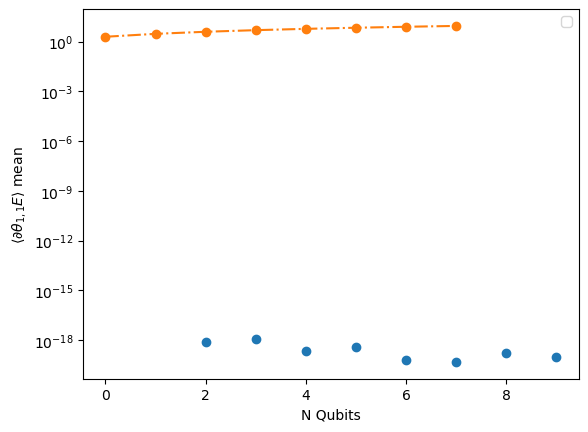

In [60]:


# Plot the straight line fit to the semilog
plt.semilogy(qubits, np.abs(means), "o")
plt.semilogy(qubits, "o-.")
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ mean")
plt.legend()
plt.show()